# Assembling the Analysis

Goal of this notebook:
* figure out how to do alle the important step
* once everything is running you can implement a script

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

from sklearn.cluster import DBSCAN
from sklearn import metrics

from random import randint
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

import time
import sys
import h5py

from math import pow
from math import ceil

from numba import jit

### Parameters for DBSCAN

Those need a review once everything runs!!

In [2]:
#parameters for DBSCAN
eps=2 #was 5
min_samples=20
algorithm='kd_tree'
n_jobs=-1

### Problem specific parameters

* file name
* density thereshold -> iterate over that?

In [3]:
dens_th = 5
data_file = '../data/axion.00059'

## Get data

Read in the data & process it for the clustering.
Still to do: read the pysical size of the grid from the file

In [4]:
@jit
def numba_pos_data(a_in, th):
    
    n3 = len(a_in)
    n = int(pow(len(data),1./3.)+10**-5)
    n2 = int(n**2)
    nth = len(np.extract(a_in>th,a_in))
    
    print ("points per axis: %d" %n)
          
    a_out = np.zeros((nth,3)) #make this an integer array?
    counter = 0
    
    for index in xrange(0,n3):
        if a_in[index]> th:
            
            i = index/n2
            j = (index - i*n2)/n
            k = (index%n2)%n
            
            a_out[counter][0] = i
            a_out[counter][1] = j
            a_out[counter][2] = k
            
            counter +=1
            
    return a_out, n

In [5]:
start = time.time()

file = h5py.File(data_file, 'r')
data = file['m'].value
file.close()
data = np.array(data)

end=time.time()
print('gettin the array from file took %1.3f s' %(end-start))

gettin the array from file took 6.654 s


In [6]:
start = time.time()

pos, n = numba_pos_data(data, dens_th)

end=time.time()
print('computing position array with numba took %1.3f s' %(end-start))

points per axis: 512
computing position array with numba took 1.398 s


## Clustering

### Step 1: Ignore periodic boundaries

In [7]:
start = time.time()
db = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos)
labels = np.array(db.labels_)
end = time.time()
print('clustering of the full dataset took %1.3f s' %(end-start))

clustering of the full dataset took 34.244 s


Plotting the whole grid (below). Works but very slow (~3 minutes on my laptop). I think because matplotlib is not too good with large ammounts of data. We won't produce many of these plots anyway, so it's not very crucial.

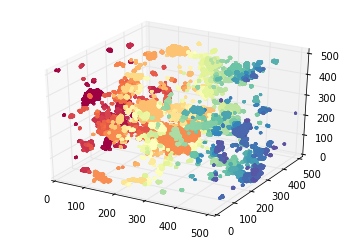

clustering of the full dataset took 193.557 s


In [8]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if (k>-1):

        class_member_mask = (labels == k)
        xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

        #plot projection on x-y plane
        #plt.plot(xyz[:, 0], xyz[:, 1], 'o', markerfacecolor=col, markersize=6)

        #3D plot
        #if ( np.size(xyz) > 3*500 ):
        ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

plt.show()

end = time.time()
print('clustering of the full dataset took %1.3f s' %(end-start))

### step 2: glue together boundaries

The DBSCAN algorithm in principle accepts a user-defined metric, where we could account for periodic boundary conditions. However, that makes the computation super slow!

The following procedure works quite well:
* 1: cut out layers at the boundaries
* 2: addjust the large indices i-> i-n, to account for periodic boundaries
* 3: rerun clustering on the boundaries
* 4: correct in the dataset of the whole grid for the newly found clusters

The only things you need to bee aware of with this procedure are
* there are jumps in the list of cluster labels
* once a point is classified noise it can't be re-assigned to a cluster

In [9]:
#parameters for DBSCAN
eps=2 #was 5
min_samples=20
algorithm='kd_tree'
n_jobs=-1

In [10]:
def get_borders(pos_in, labels_in, thickness, size):
    # this procedure counts points in the corners 3 times!
    #this shouldn't hurt
    
    pos_out = np.empty([0,3])
    labels_out = np.empty([0])
    
    for i in xrange(0,3):
        mask_u = (pos_in[:,i]<thickness)
        mask_l = (pos_in[:,i]>size-thickness)
        
        layer_u = pos_in[mask_u]
        layer_l = pos_in[mask_l]
        layer_l[:,i] = layer_l[:,i]-size
        
        labels_u = labels_in[mask_u]
        labels_l = labels_in[mask_l]
        
        layer = np.concatenate((layer_u,layer_l))
        labels = np.concatenate((labels_u, labels_l))
        
        pos_out = np.concatenate((pos_out,layer))
        labels_out = np.concatenate((labels_out,labels))
        
    return pos_out, labels_out   

In [11]:
start = time.time()
pos_b, labels_old = get_borders(pos,labels,5,n)
end =time.time()
print('slicing out the borders took %1.3f s' %(end-start))

slicing out the borders took 0.065 s


In [12]:
start = time.time()
db_b = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos_b)
labels_b = np.array(db_b.labels_)
end =time.time()
print('clustering borders took %1.3f s' %(end-start))

clustering borders took 1.022 s


In [205]:
def relabel(l_orig, l_old, l_new):
    
    #an array to save information on clusters extending over boundaries
    info_pb = np.zeros((len(set(l_new)),4), dtype=np.int)
    
    #save which old labels you already encountered (for checks).
    #the format is [old_label, new_label]
    l_encountered = np.empty([0,2]),
    
    #loop over all NEW clusters
    counter = 0
    for i in set(l_new):
        if not(i==-1):
            
            #get which OLD labels belong to a new cluster
            mask_old = (l_new == i)
            values_old = set(l_old[mask_old]) 

            #cant assign noise to a cluster
            if -1 in values_old:
                values_old.remove(-1)
                
            #if there is a cluster on the boundary, which doesn't reach over thereshold 
            #on both sides individually the algoritm won't find it    
            if (len(values_old)>0):
                
                #define one common label for the NEW clsuers
                new_index = min(values_old)
                
                #check if the new cluster is connected to one you already checked
                # *all values_old which appeared before
                # * theire new indices
                encounters = 0
                encountered_new = np.zeros(len(values_old))
                for i_old in len(values_old):
                    for i_previous in len(l_encountered(:,1)):
                        if values_old[i_old] == l_encountered[i_previous,1]:
                            encountered_new = l_encountered[i_previous,0]
                            encounters += 1
                            
                #if all previous encounters have the same value you just need to choose that as your new index
                if len(np.unique(encountered_new)) == 2
                
                #it it's connecting two formerly separated clusters you need to relable these as well
                #and change it's entry in the checklist
                
                #rename labels in original data
                for index in values_old:
                    l_orig[l_orig==index] = new_index
                    
                    #save which values you encountered & renamed
                    pos_out = np.concatenate((pos_out,layer))
                    l_encountered = np.concatenate(l_encountered,[index,new_index])

                    
                #save labels of all clusters which extend over boundaries
                #also save the direction over which tey extend
                info_pb[i,0] = new_index
                counter +=1
    
    return l_orig, info_pb

In [206]:
start = time.time()
labels, info_pb = relabel(labels, labels_old, labels_b)
end = time.time()
print('relabeling the clusters at the boundaries took %1.3f' %(end-start))

relabeling the clusters at the boundaries took 0.502


### Some tests if the gluing works as expected

Questions:
* why does the same label appear multiple times in info_pb (see below)?

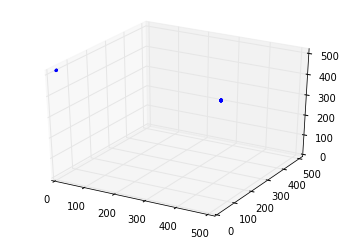

In [207]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

k=0
class_member_mask = (labels == k)
xyz = pos[class_member_mask]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], s=6, lw=0)

plt.show()

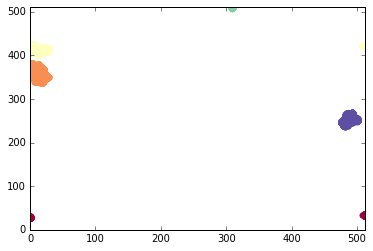

plotting the reduced dataset with only clusters extending over boundaries took 0.333 s


In [230]:
start = time.time()

plt.ylim(ymin=0,ymax=n)
plt.xlim(xmin=0,xmax=n)

#unique_labels = set(info_pb[:,0])
unique_labels = [0,9,10,777,1079]
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if (k>-1):

        class_member_mask = (labels == k)
        xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

        #plot projection on x-y plane
        plt.plot(xyz[:, 0], xyz[:, 1], 'o', markerfacecolor=col, markersize=6, markeredgecolor='none')

        #3D plot
        #if ( np.size(xyz) > 3*500 ):
        #ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

plt.show()

end = time.time()
print('plotting the reduced dataset with only clusters extending over boundaries took %1.3f s' %(end-start))

In [208]:
info_pb[:,0]

array([   0,    1,    2,    3,    4, 1144,    5,    7,    9,   10,   10,
         12,    9,   13,   14, 1132, 1108, 1154, 1140, 1153, 1078, 1151,
       1152,  140,  142,  300,  318,  291,  497,  583,  782,  815,  961,
        217,  299,  357,  432,  461,  389,  479,  777,   82,   91,   91,
        284,  331,  358,  361,  383,  397,  400,  397,  449,  465,  460,
        289,  593,  596,  594,  603,  615,  808,  841,  857,  841,  882,
        908,  882,  924,  930,  919,  958,  937,  973,  974, 1049, 1059,
       1057, 1062, 1062, 1080, 1079, 1079, 1079, 1096,    0,    0,   17,
        268,  353,  327,  449,  800,  868,  872,  984, 1005, 1075, 1122,
       1158,    0])

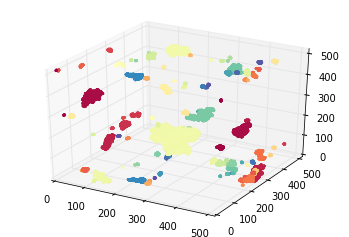

plotting the reduced dataset with only clusters extending over boundaries took 63.793 s


In [209]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

unique_labels = set(info_pb[:,0])
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if (k>-1):

        class_member_mask = (labels == k)
        xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

        #plot projection on x-y plane
        #plt.plot(xyz[:, 0], xyz[:, 1], 'o', markerfacecolor=col, markersize=6)

        #3D plot
        #if ( np.size(xyz) > 3*500 ):
        ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

plt.show()

end = time.time()
print('plotting the reduced dataset with only clusters extending over boundaries took %1.3f s' %(end-start))

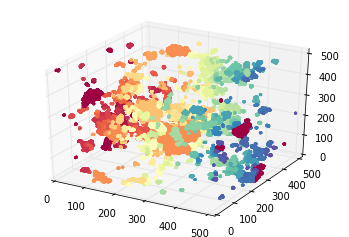

plotting the full dataset took 194.231 s


In [210]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if (k>-1):

        class_member_mask = (labels == k)
        xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

        #plot projection on x-y plane
        #plt.plot(xyz[:, 0], xyz[:, 1], 'o', markerfacecolor=col, markersize=6)

        #3D plot
        #if ( np.size(xyz) > 3*500 ):
        ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

plt.show()

end = time.time()
print('plotting the full dataset took %1.3f s' %(end-start))

## Analyzing the clusters
Still to do:
* analyze sphericity
* normalize mass

computes for every cluster:
* number of points
* sum of densities -> normalize
* center of mass (com)
* maximum distance to com

In [211]:
np.shape(pos)

(1105630, 3)

In [212]:
def mc_properties (labels, positions, densities):
    
    n_grid = int(pow(len(densities),1./3.)+10**-5)
    n_clusters = len(set(labels))
    
    #this gives back:
    # 0: number of points
    # 1: mass -> To DO: normalize
    # 3: size (=largest distance to com)
    
    mc_data = np.zeros( (3, n_clusters))
    com_list = np.zeros ( (n_clusters,3) )
    counter = 0
    
    
    for i in set(labels):
        mask = (labels==i)
        
        points = pos[mask]
        idx = np.sum(points*np.array([n**2,n,1]),axis=1,dtype=int)
        dens = densities[idx]
        
        n_points = len(idx)
        mass = np.sum(dens)
        com = np.sum(np.multiply(dens,points.transpose()),axis=1)/mass
        
        #account for periodic boundaries and check this works the way you think!
        size = np.amax( np.linalg.norm((points-com) ) )
                
        mc_data[0][counter] = n_points
        mc_data[1][counter] = mass
        mc_data[2][counter] = size
        
        #if(size > np.sqrt(3.*n_grid**2)):
         #   print('Error size too large')
            
        #if(any(com)>n):
         #   print('Error com out of grid')
        
        com_list[counter] = com
        
        #this needs to be a counter because there are jumps in the index labels
        counter+=1        
        
    return mc_data, com_list

In [213]:
start = time.time()
mc_dat, com = mc_properties(labels, pos, data)
end = time.time()
print('computing the mass spectrum took %1.3f s' %(end-start))

computing the mass spectrum took 6.562 s


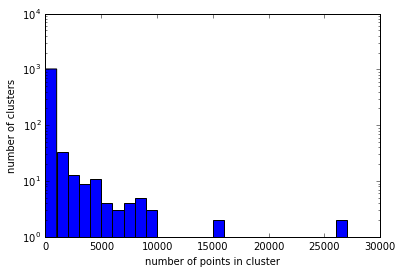

In [214]:
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('number of points in cluster')
plt.ylabel('number of clusters')
plt.hist(mc_dat[0],bins=np.array(range(0,30000,1000)))
plt.show()

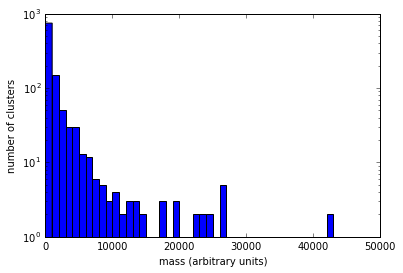

In [215]:
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('mass (arbitrary units)')
plt.ylabel('number of clusters')
plt.hist(mc_dat[1],bins=np.array(range(0,50000,1000)))
plt.show()

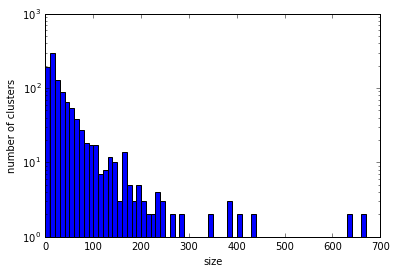

In [216]:
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('size')
plt.ylabel('number of clusters')
plt.hist(mc_dat[2],bins=np.array(range(0,700,10)))
plt.show()

location of COMs in the gris

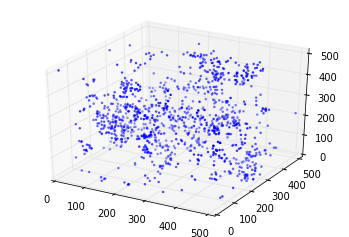

In [217]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

ax.scatter(com[:,0], com[:,1], com[:,2], s=6, lw=0)

plt.show()

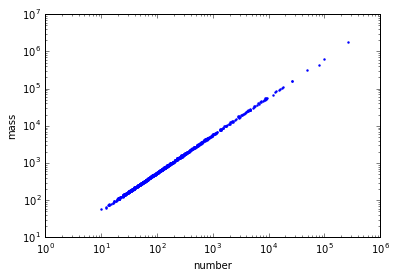

In [218]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('number')
plt.ylabel('mass')

plt.yscale('log')
plt.xscale('log')
#plt.xlim(xmin=0,xmax=3e3)
#plt.ylim(ymin=0,ymax=3e4)

ax.scatter(mc_dat[0], mc_dat[1], s=6, lw=0)

plt.show()

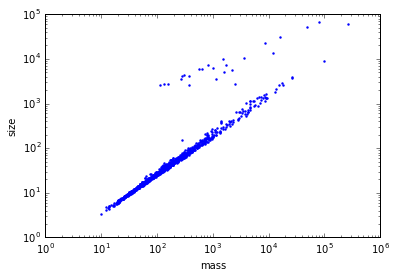

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('mass')
plt.ylabel('size')

plt.yscale('log')
plt.xscale('log')
#plt.xlim(xmin=0,xmax=1e5)
#plt.ylim(ymin=0,ymax=1e4)

ax.scatter(mc_dat[0], mc_dat[2], s=6, lw=0)

plt.show()